In [12]:
# imports
import numpy as np
import scipy as scp
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.sparse.linalg import splu
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from time import time
import scipy.stats as ss
from functools import partial
from scipy.integrate import quad
import scipy as scp
from math import factorial

# Heston

In [6]:
vars
r = None          # interest rate
sigma = None      # Heston parameter
theta = None      # Heston parameter
kappa = None      # Heston parameter
rho = None        # Heston parameter
S0 = None         # current price
v0 = None         # spot variance
K = None          # strike
T = None          # maturity in years
exercise = None
payoff = None

In [4]:
# simple payoff formula
def fpayoff(S):
        if payoff == "call":
            Payoff = np.maximum( S - K, 0 )
        elif payoff == "put":    
            Payoff = np.maximum( K - S, 0 )  
        return Payoff

## Monte Carlo

In [7]:
def MC(N, paths, Err=False, Time=False):
    """
    Heston Monte Carlo
    N = time steps
    paths = number of simulated paths
    Err = return Standard Error if True
    Time = return execution time if True
    """
    t_init = time()

    S_T, _ = Heston_paths(N=N, paths=paths, T=T, S0=S0, v0=v0, mu=r, rho=rho, 
                        kappa=kappa, theta=theta, sigma=sigma  )
    S_T = S_T.reshape( (paths,1) )
    DiscountedPayoff = np.exp(-r*T) * fpayoff(S_T) 
    V = np.mean( DiscountedPayoff, axis=0 )
    std_err = ss.sem( DiscountedPayoff )

    if (Err == True):
        if (Time == True):
            elapsed = time()-t_init
            return V, std_err, elapsed
        else:
            return V, std_err
    else:
        if (Time == True):
            elapsed = time()-t_init
            return V, elapsed
        else:
            return V        


In [24]:
def cf_Heston(u, t, v0, mu, kappa, theta, sigma, rho):
    """
    Heston characteristic function as proposed in the original paper of Heston (1993)
    """
    xi = kappa - sigma*rho*u*1j
    d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
    g1 = (xi+d)/(xi-d)
    cf = np.exp( 1j*u*mu*t + (kappa*theta)/(sigma**2) * ( (xi+d)*t - 2*np.log( (1-g1*np.exp(d*t))/(1-g1) ))\
              + (v0/sigma**2)*(xi+d) * (1-np.exp(d*t))/(1-g1*np.exp(d*t)) )
    return cf


def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
    """
    Heston characteristic function as proposed by Schoutens (2004)
    """
    xi = kappa - sigma*rho*u*1j
    d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
    g1 = (xi+d)/(xi-d)
    g2 = 1/g1
    cf = np.exp( 1j*u*mu*t + (kappa*theta)/(sigma**2) * ( (xi-d)*t - 2*np.log( (1-g2*np.exp(-d*t))/(1-g2) ))\
              + (v0/sigma**2)*(xi-d) * (1-np.exp(-d*t))/(1-g2*np.exp(-d*t)) )
    return cf

In [20]:
def fourier_inv_h():
    """
    Price obtained by inversion of the characteristic function
    """
    k = np.log(K/S0)                # log moneyness
    cf_H_b_good = partial(cf_Heston_good, t=T, v0=v0, mu=r, theta=theta, 
                              sigma=sigma, kappa=kappa, rho=rho ) 

    limit_max = 2000      # right limit in the integration                

    if payoff == "call":
        call = S0 * Q1(k, cf_H_b_good, limit_max) \
                                            - K * np.exp(-r*T) * Q2(k, cf_H_b_good, limit_max)
        return call
    elif payoff == "put":
        put = K * np.exp(-r*T) * (1 - Q2(k, cf_H_b_good, limit_max)) \
                                            - S0 * (1-Q1(k, cf_H_b_good, limit_max))
        return put
    else:
        raise ValueError("invalid type. Set 'call' or 'put'")

In [27]:
payoff='call'
fourier_inv_h()

65.27786862734618

In [13]:
%%time
np.random.seed(seed=42) 

N = 1000000             # time steps 
paths = 3               # number of paths
T = 1
T_vec, dt = np.linspace(0,T,N, retstep=True )
dt_sq = np.sqrt(dt)

S0 = 100          # spot price
X0 = np.log(S0)   # log price
v0 = 0.04         # spot variance
Y0 = np.log(v0)   # log-variance 

mu = 0.1                                           # drift
rho = -0.2                                         # correlation coefficient
kappa = 2                                          # mean reversion coefficient
theta = 0.04                                       # long-term variance
sigma = 0.3                                        # Vol of Vol - Volatility of instantaneous variance
std_asy = np.sqrt( theta * sigma**2 /(2*kappa) )   # asymptotic standard deviation for the CIR process
assert(2*kappa * theta > sigma**2)                 # Feller condition

# Generate random Brownian Motion
MU = np.array([0, 0])
COV = np.matrix([[1, rho], [rho, 1]])
W = ss.multivariate_normal.rvs( mean=MU, cov=COV, size=(paths,N-1) )
W_S = W[:,:,0]   # Stock Brownian motion:     W_1
W_v = W[:,:,1]   # Variance Brownian motion:  W_2

# Initialize vectors
Y = np.zeros((paths,N))
Y[:,0] = Y0
X = np.zeros((paths,N))
X[:,0] = X0
v = np.zeros(N)

# Generate paths
for t in range(0,N-1):
    v = np.exp(Y[:,t])    # variance 
    v_sq = np.sqrt(v)     # square root of variance 
    
    Y[:,t+1] = Y[:,t] + (1/v)*( kappa*(theta - v) - 0.5*sigma**2 )*dt + sigma * (1/v_sq) * dt_sq * W_v[:,t]   
    X[:,t+1] = X[:,t] + (mu - 0.5*v)*dt + v_sq * dt_sq * W_S[:,t]

CPU times: user 23.4 s, sys: 183 ms, total: 23.6 s
Wall time: 23.3 s


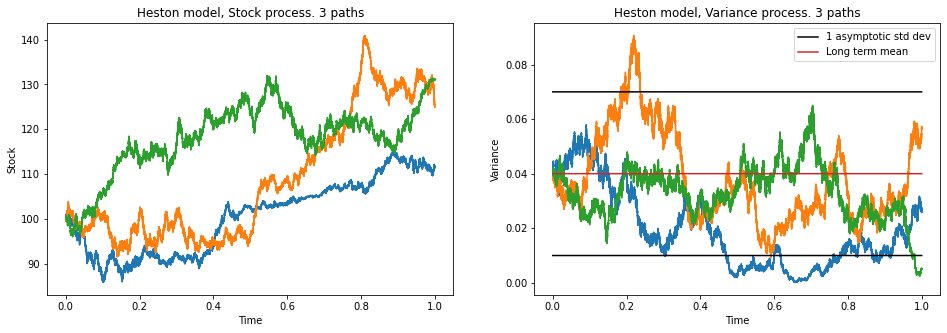

In [14]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(T_vec, np.exp(X.T) )
ax1.set_title("Heston model, Stock process. 3 paths"); ax1.set_xlabel("Time"); ax1.set_ylabel("Stock")
ax2.plot(T_vec, np.exp(Y.T) )
ax2.set_title("Heston model, Variance process. 3 paths"); ax2.set_xlabel("Time"); ax2.set_ylabel("Variance")
ax2.plot(T_vec, (theta + std_asy)*np.ones_like(T_vec), label="1 asymptotic std dev", color="black" )
ax2.plot(T_vec, (theta - std_asy)*np.ones_like(T_vec), color="black" )
ax2.plot(T_vec, theta*np.ones_like(T_vec), label="Long term mean" )
ax2.legend(loc="upper right"); 
plt.show()



## CF

In [18]:
def Q1(k, cf, right_lim):
    """
    P(X<k) - Probability to be in the money under the stock numeraire.
    cf: characteristic function
    right_lim: right limit of integration
    """
    integrand = lambda u: np.real( (np.exp(-u*k*1j) / (u*1j)) * 
                                  cf(u-1j) / cf(-1.0000000000001j) )  
    return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000 )[0]


def Q2(k, cf, right_lim):
    """
    P(X<k) - Probability to be in the money under the money market numeraire
    cf: characteristic function
    right_lim: right limit of integration
    """
    integrand = lambda u: np.real( np.exp(-u*k*1j) /(u*1j) * cf(u) )
    return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000 )[0]

In [15]:
r = 0.05                                           # drift
rho = -0.8                                         # correlation coefficient
kappa = 3                                          # mean reversion coefficient
theta = 0.1                                        # long-term mean of the variance
sigma = 0.25                                       # (Vol of Vol) - Volatility of instantaneous variance
T = 15                                             # Terminal time
K = 100                                            # Stike  
v0 = 0.08                                          # spot variance
S0 = 100                                           # spot stock price 
k = np.log(K/S0)                                   # log moneyness

In [26]:
%%time
cf_H_b_good = partial(cf_Heston_good, t=T, v0=v0, mu=r, theta=theta, sigma=sigma, kappa=kappa,rho=rho )
limit_max = 1000      # right limit in the integration                
call = S0 * Q1(k, cf_H_b_good, limit_max) - K * np.exp(-r*T) * Q2(k, cf_H_b_good, limit_max)
print("Heston Fourier inversion call price: ", call)
print("-----------------------------------")

Heston Fourier inversion call price:  65.27786862734618
-----------------------------------
CPU times: user 40.3 ms, sys: 4.02 ms, total: 44.3 ms
Wall time: 43.8 ms
